# 1. Introduction

## Guidelines
Please complete the assignment inside this notebook. Make sure the code can be executed easily.

- Write production-ready code using OOP when relevant.
- For question 1, create simple unit tests for your code where applicable.
- For question 1, add comments and documentation strings for all methods. 
- Discuss your design choices.
- For question 1 and 2, discuss the complexity (Big O notation) of your solutions, both memory wise and performance wise.
- For question3, provide map visualization when relevant
- Try to stick to the most popular scientific Python libraries.
- Provide us with the instructions needed to run your code (e.g. requirements.txt, setup.py). Ideally, a simple virtualenv build and a `pip install` will do the trick.

## PLEASE COMPLETE QUESTION 1 AND 2. YOU CAN CHOOSE BETWEEN QUESTION 3 or 4, depending on which  are you most confortable with. 

Doing both is obviously a plus :)

## Input data for question 1, 2, and 3
You should have received three csv files. Each csv-file represents the locations where a person was stationary for a certain amount of time. 
The csv-files contain the following fields:

- Latitude: The latitude of the detected GPS coordinates Longitude: The longitude of the detected GPS coordinates
- Timestamp: The start time of the stationary in the following format:
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
- Duration: The length of time the person was stationary (in milliseconds)
    
All questions in this assignment are related to this data.

In [23]:
# import statements go here.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from sklearn.cluster import DBSCAN
from scipy.signal import argrelextrema

## Question 1: Data parsing
- Create the code needed to read and parse the data.
- Print out some summary statistics of the data
    - e.g. Average number of places visited per day
    - e.g. Median distance traveled between two subsequent stationary locations
    - ...

In [24]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Description:
        Calculates the great circle distance between two points on the earth
        (specified in latitude and longitude pairs).
        Takes input in degrees, converts it to radians and gives
        output in kilometers.

    Time Complexity:
        The Sine, ArcSin, Cos etc., functions are assumed to operate in fixed time,
        hence a constant. Considering the constant and that we have n samples,
        Time Complexity is O(n) = O(n).

    Space complexity:
        Since there are n rows, Space Complexity is O(n).
    """

    # Convert decimal degrees to Radians:
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Implementing the Haversine Formula:
    dlat = np.subtract(lat2, lat1)
    dlon = np.subtract(lon2, lon1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
                        np.multiply(np.cos(lat1),
                        np.multiply(np.cos(lat2),
                        np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371.008

    return c*r

In [25]:
class Parser():
    def __init__(self, file_name):
        self.file_name = file_name
        self.header_names = ['latitude', 'longitude', 'start_date_time', 'duration', 'day_of_week']

    def file_parser(self):
        """
        Description:
            Given an input file of .csv format, parses it and returns a
            pandas dataframe.

        Time Complexity:
            if there are rows (n) x columns (m), then the read_csv function
            scans through n rows and m columns.
            Time complexity is O(n x m).

        Space Complexity:
            Space complexity is storing those n x m elements, so O(n x m).
        """

        df = pd.read_csv(self.file_name, sep = ';', names = self.header_names)

        df = df.iloc[1:]
        df['latitude'] = pd.to_numeric(df['latitude'])
        df['longitude'] = pd.to_numeric(df['longitude'])
        df['start_date_time'] = pd.to_datetime(df['start_date_time'], utc = True)
        df['duration'] = pd.to_timedelta(df['duration'], unit = 'hours')
        df['day_of_week'] = df['start_date_time'].dt.day_name()

        return df

class UserLocation():
    def __init__(self, file_name):
        self.file_name = file_name
        self.df = Parser(self.file_name).file_parser()

    def places_visited_statistics(self):
        """
        Description:
            Class to calculate some statistics given the person's location data
            and time stamps. Initializes a parsed .csv file as a pandas dataframe.

        Time Complexity:
            The column 'start_data_time' is sorted into groups by date and mean is calculated on them,
            Time complexity for sorting and grouping is n x log(n) and for calculating mean is n.
            Hence Time Complexity is O(n x log(n) + n) = O(n log(n)).

        Space complexity:
            Since there are n rows, Space Complexity is O(n).
        """

        stats = self.df['start_date_time'].dt.date.value_counts()
        return int(round(stats.describe().mean()))

    def median_dist_calc_utm(self):
        """
        Description:
            Calculates the median distance travelled between subsequent locations.
            Haversine metric is used as the distance metric between two points.

        Time Complexity:
            If the function 'haversine_vectorized()' takes constant time to calculate
            the distance in kms, that is all mathematical operations like additions, multiplications, power etc.
            takes m in time, then time complexity is O(n x m)

        Space Complexity:
            Since there are n rows, Space Complexity is O(n)
        """

        distance = haversine_vectorized(lat1=self.df['latitude'].shift(),
                                        lon1=self.df['longitude'].shift(),
                                        lat2=self.df.loc[1:, 'latitude'],
                                        lon2=self.df.loc[1:, 'longitude'])

        return np.nanmedian(distance).round(3)

In [26]:
# Code to read a given .csv file and parse it.
file_person_1 = 'Copy of person.1.csv'
user_locator = UserLocation(file_person_1)

# Average number of places visited per day
avg_no_of_places_visited_per_day = user_locator.places_visited_statistics()
print('Average no of places visited per day: {}'.format(avg_no_of_places_visited_per_day))

# Median distance traveled between two subsequent stationary locations
median_distance_traveled = user_locator.median_dist_calc_utm()
print('Median distance travelled: {}'.format(median_distance_traveled))

Average no of places visited per day: 17
Median distance travelled: 0.465


## Question 2: Data lookup
Create a method that generates a lookup table allowing us to efficiently check whether or not a user has ever visited a location even if the new location is not exactly the same as the visited location (some noise is added to the longitude/latitude pairs).

In [27]:
def location_lookup(data_frame, lat_long_lookup, threshold_distance = 0.465):

    lat_all = data_frame['latitude']
    lon_all = data_frame['longitude']
    lat2 = lat_long_lookup[0]
    lon2 = lat_long_lookup[1]

    lookup_table = {}
    for i in range(len(data_frame)):
        lat1 = lat_all.iloc[i]
        lon1 = lon_all.iloc[i]
        distance = haversine_vectorized(lon1, lat1, lon2, lat2)
        lookup_table.update({(lon1, lat1) : distance})

    closest_point = min(lookup_table.values())

    if closest_point < threshold_distance:
        print('Visited')
    else:
        print('Not Visited')

    return lookup_table

    Given a query location in latitude and longitude pair, the 'location_lookup' function
    function calculates the haversine distance between each point that the person has visited and the query point.
    This generates a dictionary (look up table) with existing locations as keys and the distance to the query location as values.

    I have assumed that if the query location is within 500 meters from the existing locations,
    then it is likely that the person has visited this location previously.

In [28]:
# reads and parses the file to create a pandas dataframe. 'df' will be used in the subsequent methods.
df_parser = Parser(file_person_1)
df = df_parser.file_parser()

query_location = (-49.328958, -72.89073)
look_up_table = location_lookup(df, query_location)

Visited


## Question 3: Home and work detection
The goal of this question, is to design an unsupervised algorithm that allows one to distinguish the likely home locations of a user from his likely work locations.

Note that a person might have multiple home and work locations, or might not have a work location at all. Also note that some data points might be noisy, incorrect and/or incomplete.

Discuss your choice of algorithms, rules, methods, distance measures, etc.

In [29]:
# Cartesian and Geographic plotting functions
def cartesian_plotter(data_frame, labels, ax, additional_text):

    for i in set(labels):
        ax[0].scatter(data_frame[labels == i]['longitude'],
                      data_frame[labels == i]['latitude'],
                      edgecolor = 'None', alpha = 0.3, s = 120)

    ax[0].set_title('GPS Projection - ' + additional_text)
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].legend(set(labels))

def geographic_plotter(data_frame, ax, additional_text):

    lon_min = data_frame['longitude'].min() - 2
    lon_max = data_frame['longitude'].max() + 2
    lat_min = data_frame['latitude'].min() - 2
    lat_max = data_frame['latitude'].max() + 2

    lat = data_frame['latitude'].values
    lon = data_frame['longitude'].values

    ax[1] = Basemap(llcrnrlon = lon_min,
                    llcrnrlat = lat_min,
                    urcrnrlon = lon_max,
                    urcrnrlat = lat_max,
                    lat_0 = (lat_max - lat_min)/2,
                    lon_0 = (lon_max-lon_min)/2,
                    projection = 'merc',
                    resolution = 'l',
                    area_thresh = 10000.)

    # convert lat and lon to map projection coordinates
    lons, lats = ax[1](lon, lat)

    ax[1].drawcoastlines()
    ax[1].drawcountries()
    ax[1].drawstates()
    ax[1].drawmapboundary(fill_color = '#46bcec')
    ax[1].fillcontinents(color = 'white',lake_color = '#46bcec')
    ax[1].scatter(lons, lats, marker = 'o', color = 'r', zorder = 5)

    plt.title('Map Projection - ' + additional_text)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

In [30]:
# Function that does the DBSCAN clustering with respect to earth specific distance as epsilon.
def dbscan_cluster(data_frame, threshold_distance):

    lat_lon_coordinates = data_frame[['longitude','latitude']].to_numpy()

    kms_per_radian = 6371.0088
    epsilon = threshold_distance/kms_per_radian

    # db scan would kindly like the values in radians if haversine metric is used. Thank you.
    db_scan = DBSCAN(eps = epsilon, algorithm = 'ball_tree', metric = 'haversine', min_samples = 5, n_jobs = 4)
    db_scan.fit(np.radians(lat_lon_coordinates))

    cluster_labels = db_scan.labels_

    return cluster_labels

def cart_georaph_plotter(data_frame, labels, ana_type):

    fig, ax = plt.subplots(1, 2, figsize = (14,7))

    cartesian_plotter(data_frame, labels, ax, ana_type + ' Locations')
    geographic_plotter(data_frame, ax, ana_type + ' Locations')

    plt.subplots_adjust(wspace = 0.0)
    plt.show()

def sub_cluster_location(data_frame, counts, labels, cluster_ids, ana_type):

    # even more work location filtering
    maximums_indices = argrelextrema(counts, np.greater_equal, mode = 'wrap')

    for i in range(len(maximums_indices[0])):
        data_frame_new = data_frame[labels == cluster_ids[maximums_indices[0][i]]]

    # sub clustering work
    labels_new = dbscan_cluster(data_frame_new, threshold_distance = 0.050)

    # outlier elimination
    data_frame_new = data_frame_new[labels_new != -1]
    labels_new = labels_new[labels_new != -1]

    cluster_ids_new, counts_new = np.unique(labels, return_counts = True)
    print('Number Of Likely ' + ana_type + ' Location(s): {}' .format(len(cluster_ids_new)))
    print('Cluster IDs: {}'.format(cluster_ids_new))
    print('Number of Locations: {}' .format(counts_new))
    print('Local Maxima Location Index: {}'.format(maximums_indices[0]))

    cart_georaph_plotter(data_frame_new, labels_new, ana_type)

In [31]:
def home_work_locator(data_frame):

    data_frame = data_frame.set_index('start_date_time')

    weekday_df = data_frame.loc[data_frame['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday' 'Friday'])]
    weekend_df = data_frame.loc[data_frame['day_of_week'].isin(['Saturday', 'Sunday'])]

    # work locations
    work_df = weekday_df.between_time('09:00', '17:30')
    work_df = work_df.reset_index()

    # home locations
    home_df_1 = weekday_df.between_time('21:00', '05:30')
    home_df_2 = weekend_df.between_time('01:00', '05:30')
    home_df = pd.concat([home_df_1, home_df_2])
    home_df = home_df.reset_index()

    # Work clustering
    labels = dbscan_cluster(work_df, threshold_distance = 0.250)

    # outlier elimination
    work_df = work_df[labels != -1]
    labels = labels[labels != -1]

    cluster_ids, counts = np.unique(labels, return_counts = True)
    print('Number of likely work location cluster(s): {}' .format(len(cluster_ids)))
    print('Cluster IDs: {}'.format(cluster_ids))
    print('Number of locations in clusters: {}' .format(counts))

    cart_georaph_plotter(work_df, labels, 'Work')

    # Further work location filtering
    sub_cluster_location(work_df, counts, labels, cluster_ids, 'Work')

    print('----------------------------------------------------')

    # Home clustering
    labels = dbscan_cluster(home_df, threshold_distance = 0.250)

    # Outlier elimination
    home_df = home_df[labels != -1]
    labels = labels[labels != -1]

    cluster_ids, counts = np.unique(labels, return_counts = True)
    print('Number of likely home location cluster(s): {}' .format(len(cluster_ids)))
    print('Cluster IDs: {}'.format(cluster_ids))
    print('Number of locations in clusters: {}' .format(counts))

    cart_georaph_plotter(home_df, labels, 'Home')

    # Further home location filtering
    sub_cluster_location(home_df, counts, labels, cluster_ids, 'Home')

    I use a three stage approach to solve this problem.

    The initial assumptions are that a likely home location is one at which a person spends his evenings during the weekdays and the weekends.
    Also that most time spend being stationary would be at home during the night.
    Similarly, a likely work location is one at which a person spends most of the morning and afternoon at.

    An initial clustering stage with the DBSCAN algorithm with the cluster radius being 250 meters (epsilon tens to be 0.250(km)/radius of the earth(km))
    gives me a group of clusters and the number of points within them.

    In the second stage I proceed to find the local maxima using 'argrelextrema' in this set of number of locations.
    This gives me the maxima peaks of the number of locations.

    In the third stage I proceed to consider only these maxima peak locations for a second clustering step with the DBCAN,
    but this time with a cluster radius of 50 meters. This is under the assumption that in a likely home or work location area
    the maximum dstance between a person's movements would be within 50 meters. This further results in a refined set of likely home and work locations.

    The method works well enoguh even when there are multiple likely home and work locations, or no specific work locations at all.

    The flow can be recognized as:
    initial clustering -> local maxima filter -> final clustering

    A textual and visual representation in both the cartesian and geographic forms are displayed which shows the
    initial clustering and the refined clustering.

    I use the DBSCAN Clustering algorithm due two main purposes:
    * It allows me to specify the Haversine distance as a metric for calculating the distance between two locations.
    The haversine distane is required since the location (latitude longitude pairs) is given in world coordinates and hence the
    great circle distance needs to be used and not a simple eucledian distance.
    * It is resilient to outliers and is able to identify intertwined clusters since it mainly works based on density.

Number of likely work location cluster(s): 7
Cluster IDs: [0 1 2 3 4 5 6]
Number of locations in clusters: [ 9  7 36  8  5 21  6]
Number Of Likely Work Location(s): 7
Cluster IDs: [0 1 2 3 4 5 6]
Number of Locations: [ 9  7 36  8  5 21  6]
Local Maxima Location Index: [0 2 5]
----------------------------------------------------
Number of likely home location cluster(s): 4
Cluster IDs: [0 1 2 3]
Number of locations in clusters: [22  5  6  8]
Number Of Likely Home Location(s): 4
Cluster IDs: [0 1 2 3]
Number of Locations: [22  5  6  8]
Local Maxima Location Index: [0]


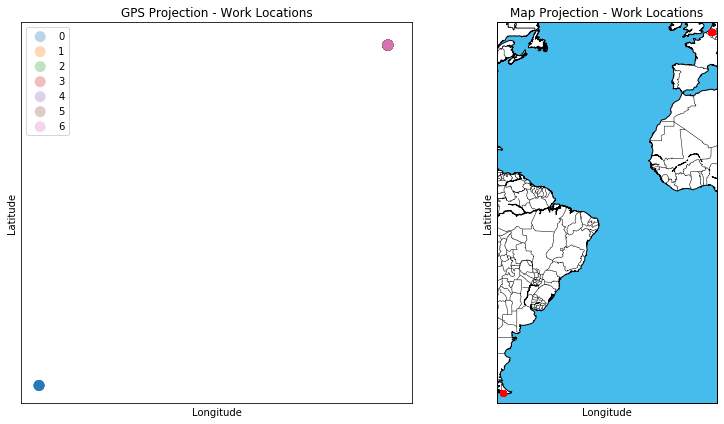

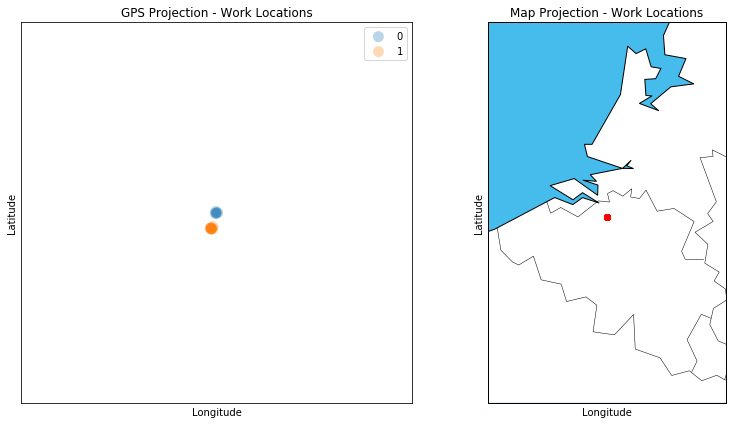

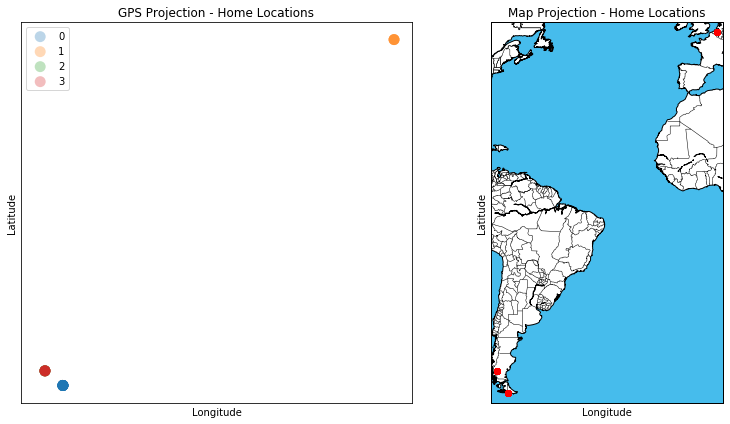

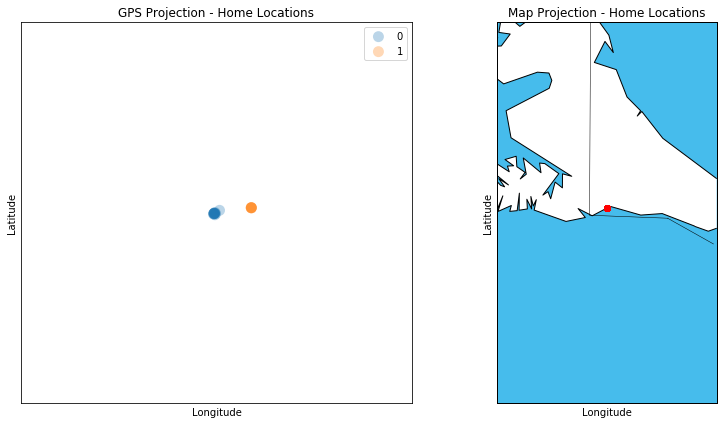

In [32]:
home_work_locator(df)

#### Resources and References:

* How to calculate distances in world coordinates
  https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

* Epsilon calculation of the DBSCAN algorithm
  https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/